# Solving Cart-Pole problem: Q-Learning

# 1. Initializing environment Q-table

In [7]:
from IPython.display import clear_output 
import matplotlib.pyplot as plt
import numpy as np
import gym
import math
import random
# Initialize environment

env = gym.make('CartPole-v1')
# Number of discrete states (bucket) per state
NUM_BUCKETS = (3, 3, 6, 6)  # (position, velocity, angle, angular velocity)
# Number of discrete actions. in our case, there are only two possible actions: left, and right
NUM_ACTIONS = env.action_space.n
# Setting bounds for each discrete state. 
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))#state bound of Cart Position, Cart Velocity
STATE_BOUNDS[1] = [-0.5, 0.5]#maximum velocity of the cart
STATE_BOUNDS[3] = [-math.radians(50), math.radians(50)]#maximum angular velocity of the cart
## Creating a Q-Table for each state-action pair
q_table = np.zeros(NUM_BUCKETS + (NUM_ACTIONS,))

# 2. Defining training related constants


In [8]:
## Learning related constants
MIN_EXPLORE_RATE = 0.01
MIN_LEARNING_RATE = 0.1

## Defining the simulation related constants
NUM_EPISODES = 10000
MAX_TIMESTEP = 250 # maximum possible timestep
SOLVED_TIMESTEP = 199# the episode is considered as solved if t > 199
STREAK_TO_END = 120 #the problem is considered as solved if the streak >120

# 3. Decaying explore_rate and learning_rate implementation
explore rate is the probability of taking random action

learning rate determines the update speed of the q-value on the q-table

with the functions below, both rate start as very high, then decay gradually as the episode goes

In [9]:
DECAY = 25
def get_explore_rate(episode):
    if episode >= DECAY-1:
        return max(MIN_EXPLORE_RATE, min(1, 1.0 - math.log10((episode+1)/DECAY)))
    else:
        return 1.0

def get_learning_rate(episode):
    if episode >= DECAY-1:
         return max(MIN_LEARNING_RATE, min(0.5, 1.0 - math.log10((episode+1)/DECAY)))
    else:
         return 1.0

# 4. Bucketing function
This function receives a continuous state as an input and then returns a discrete state as an output.

In [10]:
def state_to_bucket(state):
    bucket_indice = []
    for i in range(len(state)):
        max_bucket = NUM_BUCKETS[i] - 1
        minimum = STATE_BOUNDS[i][0]
        maximum = STATE_BOUNDS[i][1]
        state_value = state[i]
        if state_value <= minimum:
            bucket_index = 0
        elif state_value >= maximum:
            bucket_index = max_bucket
        else:
            # Mapping the state bounds to the bucket array. bucket_index*(min-max normalized state)
            bound_width = maximum - minimum
            bucket_index = int(round(max_bucket*(state_value - minimum)/bound_width))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)

# 5. The Simulation code.
The simulate() function runs the cartpole environment, recieve state and reward, take action, then repeats




In [11]:
def simulate():
    ## Instantiating the learning related parameters
    learning_rate = get_learning_rate(0)
    explore_rate = get_explore_rate(0)
    discount_factor = 0.99  # since the world is unchanging
    rewards = list()
    num_streaks = 0
    global q_table
    for episode in range(NUM_EPISODES):

        # Reset the environment
        obv = env.reset()

        # the initial state
        state_0 = state_to_bucket(obv)

        for t in range(MAX_TIMESTEP):
            env.render(mode='ansi')

            # Select an action
            action = select_action(state_0, explore_rate)

            # Execute the action then take the results.observation, reward, done, info
            obv, reward, done, _ = env.step(action)

            # Observe the result
            state = state_to_bucket(obv)
            
            max_future_q = np.max(q_table[state])

            current_q = q_table[state_0 + (action,)]

            new_q = (1 - learning_rate) * current_q + learning_rate * (reward + discount_factor * max_future_q)

            q_table[state_0 + (action,)] = new_q

            
            # Setting up for the next iteration
            state_0 = state
            
            #done: the cart failed to maintain balance
            if done:
                break

        X=np.arange(0,episode+1)
        rewards.append(t)
        Y=rewards
        clear_output()
        plt.plot(X,Y)
        plt.xlabel('episodes')
        plt.ylabel('reward')
        plt.show()
        print("Episode %d finished after %f time steps. Streak: %d" % (episode, t, num_streaks))

        #The episode is considered as a success if timestep >SOLVED_TIMESTEP 
        if (t >= SOLVED_TIMESTEP):
            num_streaks += 1
        else:
            num_streaks = 0
            
        #  when the agent 'solves' the environment: steak over 120 times consecutively
        if num_streaks > STREAK_TO_END:
            print("The Environment is solved")
            break

        # Update parameters
        explore_rate = get_explore_rate(episode)
        learning_rate = get_learning_rate(episode)
    env.close()#closes window


def select_action(state, explore_rate):
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = np.argmax(q_table[state])
    return action


# ASSIGNMENT
new_q = (1 - learning_rate) * current_q + learning_rate * (reward + discount_factor * max_future_q)라는 식을 추가하여 계속해서 Q-테이블을 업데이트 시켜나가도록 했다.

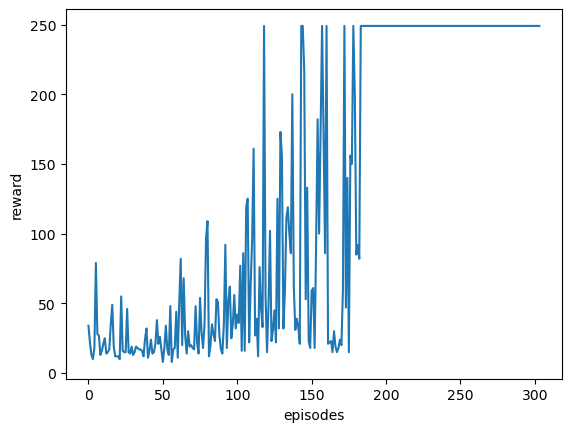

Episode 303 finished after 249.000000 time steps. Streak: 120
The Environment is solved


: 

In [12]:
simulate()